### Fraud Detection

In [2]:
## Importing required libraries

# Importing basic packages
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Utility packages
from collections import Counter

# Importing ML packages
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

In [14]:
# Download the dataset file from https://www.kaggle.com/mlg-ulb/creditcardfraud and store it in data folder
# loading data from csv file
creditcard_data = pd.read_csv("data\creditcard.csv.zip")

In [13]:
creditcard_data.shape

(284807, 31)

In [48]:
creditcard_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### EDA

The data is credit card transaction information, hence is anomalized by using PCA dimensionality reduction to protect user identities and sensitive features and only the colums Time, Amount and Class are currently considered.

- Time: Is defined as the number of seconds elapsed between this transaction and the first transaction in the dataset.

- Amount: Transaction amount

- Class: 1 for fraudulent transactions, 0 otherwise

In [5]:
def secondsToDays(secs):
    days = round((secs/86400),0)
    return days

maxseconds = creditcard_data['Time'].max()
print('Transaction data is available for: %s days' %secondsToDays(maxseconds))

Transaction data is available for: 2.0 days


#### Initial observation:

- The initial observation suggests that the data is just 2 days old from the 'time' feature.

In [6]:
# def plotHist(column_data, bins, title,xlabel='Bins',ylabel='Values', figsizex=13, figsizey=8):
#     plt.figure(figsize=(figsizex,figsizey))
#     plt.style.use('seaborn-whitegrid')
    
#     n, bins, patches = plt.hist(column_data, bins=bins, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
    
#     #n = n.astype('int')
#     # Good old loop. Choose colormap of your taste
#     #for i in range(len (patches)):
#      #   patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
        
#     # Make one bin stand out
#     #patches[22].set_fc('red') # Set color
#     #patches[22].set_alpha(1) # Set opacity
    
#     plt.title(title, fontsize=12)
#     plt.xlabel(xlabel, fontsize=10)
#     plt.ylabel(ylabel, fontsize=10)
#     plt.show()

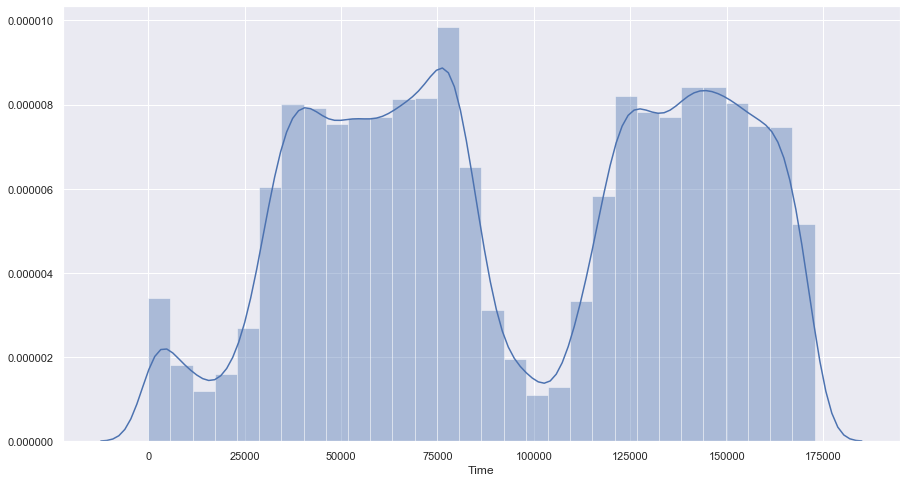

In [7]:
# plotHist(creditcard_data.Time, 50, 'Time Distribution(seconds)');

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15,8)})
sns.distplot(creditcard_data.Time, bins=30);

The distribution of transaction follow the pattern show above is expected as most transaction happen during the day and the distribution goes down until next day. Since we have 2 days worth of transactions we notice two distributions here.

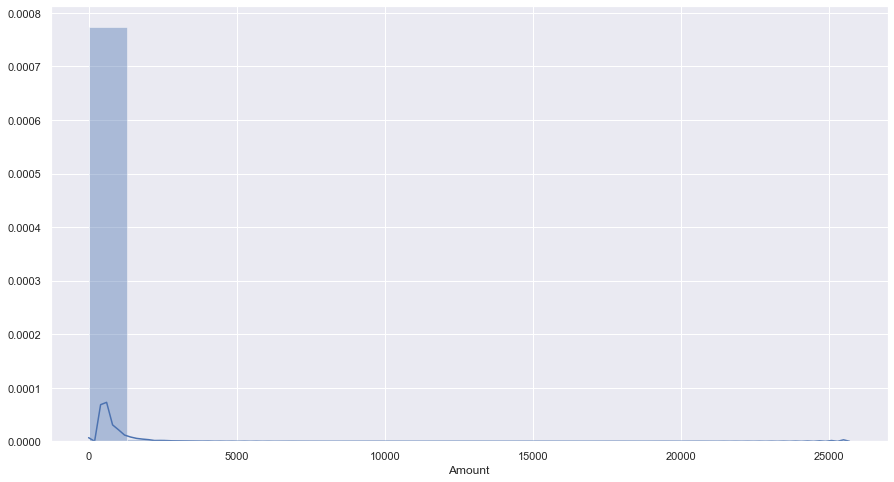

In [8]:
#plotHist(creditcard_data.Amount, 20, 'Amount Distribution');
sns.distplot(creditcard_data.Amount, bins=20);

This distribution is also expected since most of the transaction values will be very low under 50 dollars. However, most of the transaction fall in this section thus most fraudulent transactions also happen below $50 as well.

In [9]:
creditcard_data.Amount.value_counts(bins=10)

(-25.692, 2569.116]       284395
(2569.116, 5138.232]         360
(5138.232, 7707.348]          36
(7707.348, 10276.464]         10
(17983.812, 20552.928]         2
(10276.464, 12845.58]          2
(23122.044, 25691.16]          1
(12845.58, 15414.696]          1
(20552.928, 23122.044]         0
(15414.696, 17983.812]         0
Name: Amount, dtype: int64

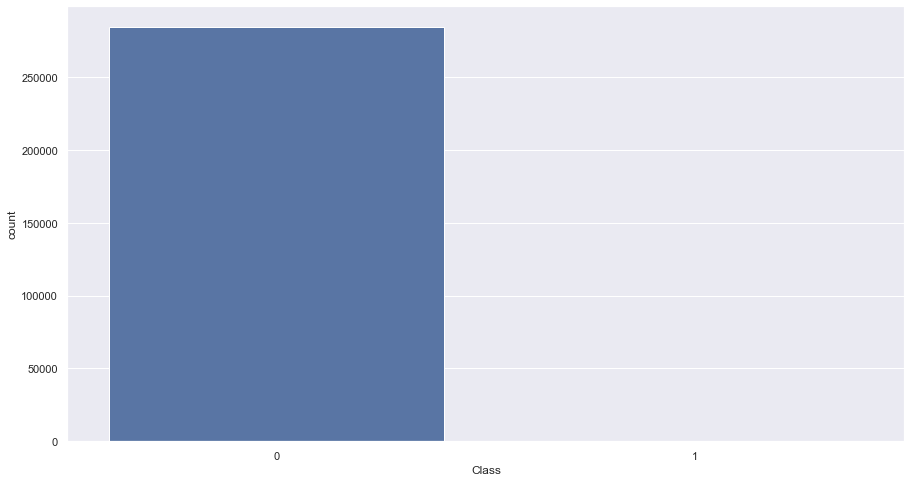

In [10]:
#plotHist(creditcard_data.Class, 2,'Fraud vs Non-Fraud Transactions')
sns.countplot(creditcard_data.Class);

In [11]:
creditcard_data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

There is a very small amount of fraud transactions which amount to 492 transactions which is 0.173 percent of the overall transactions

In [12]:
creditcard_data[['Amount','Class']].groupby('Class')['Amount'].mean()

Class
0     88.291022
1    122.211321
Name: Amount, dtype: float64

We can see that the mean amount of fraud higher than the non-fraudulent transactions.

### Data processing

In this step, we will start analysing the collinearity between the features which can create a problem

In [13]:
creditcard_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We can notice from the 'max' value, the time and amount are at different scales and need to be scaled down to a normal distribution with mean 0 and standard deviation of 1.

In [14]:
# Scaling amount and time

# Create the Scaler
ss = StandardScaler()

# Take a subset of the dataframte to scale
creditcard_scaled_data = creditcard_data.copy()

col_names = ['Time','Amount']
features = creditcard_scaled_data[col_names]

creditcard_scaled_data[col_names] = ss.fit_transform(features.values)
# creditcard_scaled_data.head()

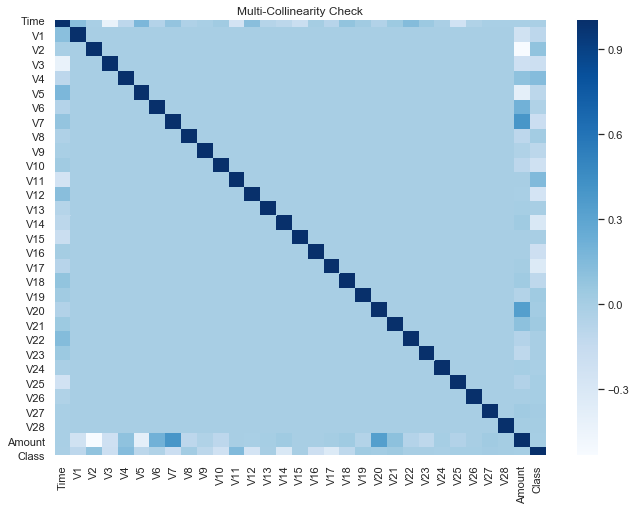

In [15]:
fig,ax = plt.subplots(figsize=(11,8))
sns.heatmap(creditcard_scaled_data.corr(), cmap='Blues')

ax.set_title('Multi-Collinearity Check');

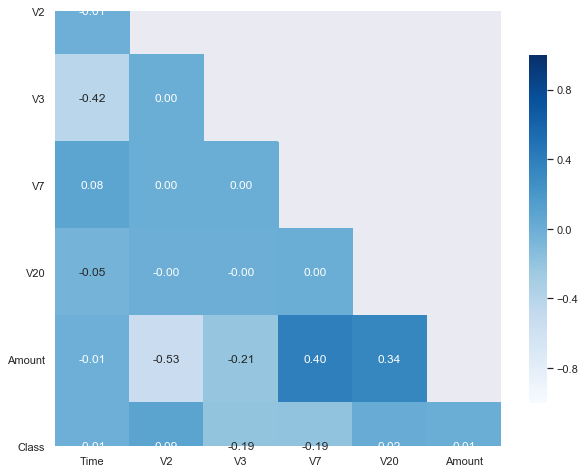

In [16]:
fig, ax = plt.subplots(figsize=(10,8))

corr_df = creditcard_scaled_data[['Time','V2','V3','V7','V20','Amount','Class']].corr()
# mask
mask = np.triu(np.ones_like(corr_df, dtype=np.bool))

# adjust mask and df
mask = mask[1:, :-1]
corr = corr_df.iloc[1:,:-1].copy()

# plt heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="Blues",
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})

# yticks
plt.yticks(rotation=0)

plt.show()

In [17]:
# creditcard_scaled_data.corr()

Below are few of our observations:

- Time has negative correlation with V3 of about -0.42
- Amount has negative correlation with V2 of about -0.53
- Amount has possitive correlation with V4 of about 0.4

Since, these values aren't near 0.8 these isn't much risk of multicollinearlity.

Yet another noticeable observation from our analysis of the target variable 'feature' is the imbalance of data where we have very small percentage of 0.173 fraudulent transactions and remaining are non-fraudulent transactions which is the major class.

- The ROC curve doesn't work well with imbalanced data. Hence, we are using the random undersampling to decrease the number of non-fraudulent transactions and match it to the amount of fraudulent transactions.

In [18]:
# Random under sampling major class

X = creditcard_scaled_data.iloc[:,0:30]
y = creditcard_scaled_data.iloc[:,-1]

os = RandomUnderSampler(sampling_strategy='majority')
X_new, y_new = os.fit_resample(X,y)

In [19]:
print(Counter(y))
print(Counter(y_new))

Counter({0: 284315, 1: 492})
Counter({0: 492, 1: 492})


In [20]:
# Splitting the dataset into train test subsets

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=1) # 0.25 * 0.8 = 0.2

In [21]:
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(y_train))
print(len(y_val))
print(len(y_test))

590
197
197
590
197
197


## Logistic Regression

In [22]:
# Logistic Regression Model Fitting

logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression()

In [23]:
y_pred_logreg = logreg_model.predict(X_test)
print('Accuracy of logistic regression classifer on test set:{:.2f}'
      .format(logreg_model.score(X_test,y_test)))

Accuracy of logistic regression classifer on test set:0.94


In [24]:
confusionmatrix = pd.DataFrame(confusion_matrix(y_test, y_pred_logreg), columns=['Predicted Non-Fraudulent','Predicted Fraud'],
                              index=['Actual Non-Fradulent','Actual Fradulent'])
confusionmatrix

,Predicted Non-Fraudulent,Predicted Fraud
Actual Non-Fradulent,94,1
Actual Fradulent,11,91


In [25]:
print(Counter(y_test))
print(Counter(y_pred_logreg))

Counter({1: 102, 0: 95})
Counter({0: 105, 1: 92})


In [26]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94        95
           1       0.99      0.89      0.94       102

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



## Naive Bayes

In [27]:
bnb_model = BernoulliNB()
bnb_model.fit(X_train,y_train)

BernoulliNB()

In [28]:
y_pred_bnb = bnb_model.predict(X_test)
print('Accuracy of Naive bayes classifier on test set:{:.2f}'
     .format(bnb_model.score(X_test,y_test)))

Accuracy of Naive bayes classifier on test set:0.87


In [29]:
confusionmatrix_bnb = pd.DataFrame(confusion_matrix(y_test,y_pred_bnb),columns=['Predicted Non-Fraudulent','Predicted Fraudulent'],
                                   index=['Actual Non-Fraudulent','Actual Fraudulent'])
confusionmatrix_bnb

,Predicted Non-Fraudulent,Predicted Fraudulent
Actual Non-Fraudulent,95,0
Actual Fraudulent,26,76


In [31]:
print((Counter(y_test)))
print((Counter(y_pred_bnb)))

Counter({1: 102, 0: 95})
Counter({0: 121, 1: 76})


In [32]:
print(classification_report(y_test, y_pred_bnb))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        95
           1       1.00      0.75      0.85       102

    accuracy                           0.87       197
   macro avg       0.89      0.87      0.87       197
weighted avg       0.90      0.87      0.87       197



## Random forest

In [33]:
rf_model = RandomForestClassifier(n_estimators=100,
                                 bootstrap=True,
                                 max_features='sqrt')
rf_model.fit(X_train,y_train)

RandomForestClassifier(max_features='sqrt')

In [34]:
# Class prediction using random forest
y_pred_rf = rf_model.predict(X_test)
print('Accuracy of Random forest classifier on test set:{:.2f}'
      .format(rf_model.score(X_test,y_test)))

Accuracy of Random forest classifier on test set:0.94


In [35]:
confusionmatrix_rf = pd.DataFrame(confusion_matrix(y_test,y_pred_rf), columns=['Predicted Non-Fraudulent', 'Predicted Fraudulent'],
                                  index= ['Actual Non-Fraudulent', 'Actual Fraudulent'])
confusionmatrix_rf

,Predicted Non-Fraudulent,Predicted Fraudulent
Actual Non-Fraudulent,95,0
Actual Fraudulent,11,91


In [36]:
print((Counter(y_test)))
print((Counter(y_pred_rf)))

Counter({1: 102, 0: 95})
Counter({0: 106, 1: 91})


In [37]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        95
           1       1.00      0.89      0.94       102

    accuracy                           0.94       197
   macro avg       0.95      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197



## ROC Curve

In [38]:
from sklearn.metrics import roc_auc_score



# Probability predictions using all the models
def get_prob_pred(model): return model.predict_proba(X_test)[:,1]

# Calculate roc auc score
def get_roc_score(proba): return roc_auc_score(y_test,proba)

y_pred_logreg_proba = get_prob_pred(logreg_model)
y_pred_bnb_proba = get_prob_pred(bnb_model)
y_pred_rf_proba = get_prob_pred(rf_model)

# Calculating roc auc
roc_value_logreg = get_roc_score(y_pred_logreg_proba)
roc_value_bnb = get_roc_score(y_pred_bnb_proba)
roc_value_rf = roc_auc_score(y_test,y_pred_rf_proba)

In [39]:
print(roc_value_logreg)
print(roc_value_bnb)
print(roc_value_rf)

0.9724458204334365
0.9405572755417957
0.9764189886480907


In [44]:
def get_preds(threshold,probabilities): return [1 if p>threshold else 0 for p in probabilities]

def get_roc_plot(y_test, y_pred_proba,title):
    roc_values = []
    for thres in np.linspace(0,1,100):
        preds = get_preds(thres, y_pred_proba)
        tn,fp,fn,tp = confusion_matrix(y_test, preds).ravel()
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        roc_values.append([tpr, fpr])
    tpr_values, fpr_values = zip(*roc_values)
    
    # Plotting ROC
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(fpr_values,tpr_values)
    ax.plot(np.linspace(0,1,100),
           np.linspace(0,1,100),
           label='baseline',
           linestyle='--')
    
    plt.title(title, fontsize=18)
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)
    plt.legend(fontsize=12)

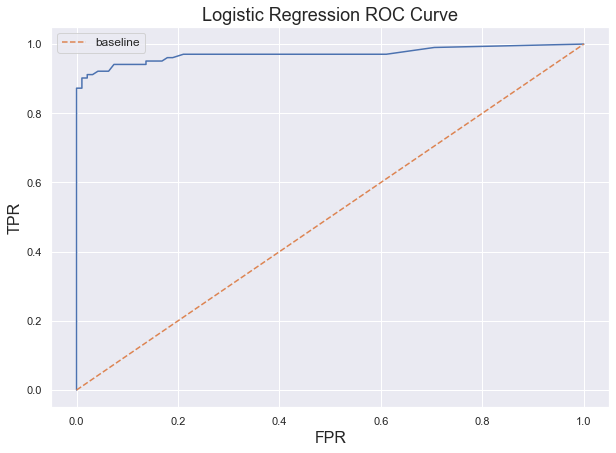

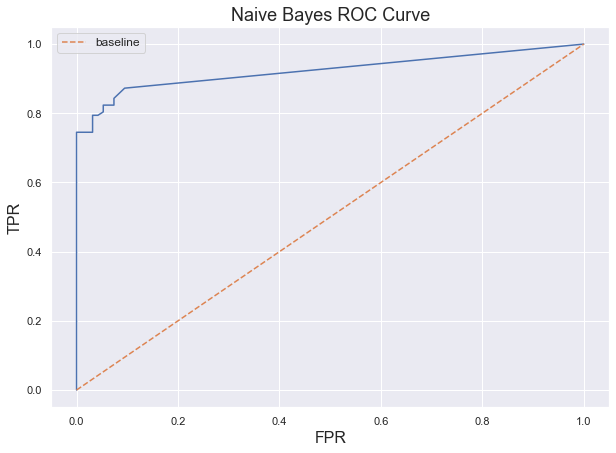

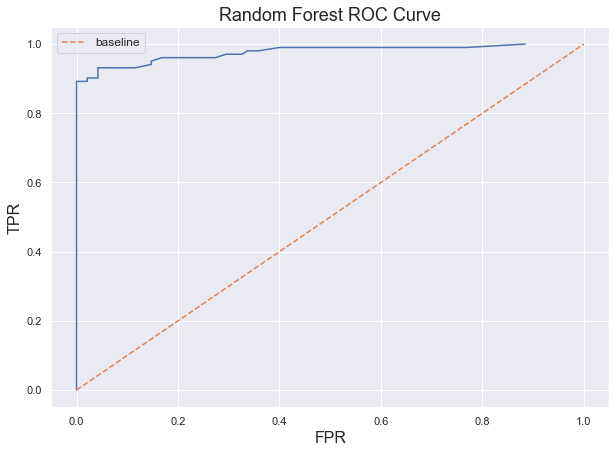

In [45]:
# Plotting ROC

get_roc_plot(y_test, y_pred_logreg_proba, 'Logistic Regression ROC Curve')
get_roc_plot(y_test, y_pred_bnb_proba, 'Naive Bayes ROC Curve')
get_roc_plot(y_test, y_pred_rf_proba, 'Random Forest ROC Curve')